# Aprendizado de Máquina

### Este documento apenas tem objetivo para fins exploratórios. Ele não agrega a nada sobre o relatório principal. Nele, testei e explorei possibilidades acerca de utilizar algoritmos envolvendo Gradient Boosting, porém, devido a inconscitência dos dados, isto é, ser um Random Walk extremamente volátil, junto a um desbalanceamento de emissões de casos, tornou-se dificultoso um trabalho para se chegar em um modelo que apresentasse uma acurácia consistente, se baseando no erro percentual absoluto médio simétrico.

In [122]:
import plotly.express as px
import pandas as pd
import numpy as np
import requests
import gzip
import plotly.graph_objects as go

In [123]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss

In [124]:
from numpy import ravel
import sklearn.model_selection
from sktime.forecasting.compose import make_reduction
from skopt import dummy_minimize
from lightgbm import LGBMRegressor
from statsmodels.tsa.filters.hp_filter import hpfilter
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [125]:
url = 'https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv.gz?raw=true'
r = requests.get(url, allow_redirects=True)
open('data.csv.gz','wb').write(r.content)
gz = gzip.open('data.csv.gz')
df = pd.read_csv(gz)

## Validação de Modelos

In [126]:
total_de_casos_amazonas = df.query("state == 'AM'").groupby('date').sum()
total_de_casos_amazonas.index = pd.to_datetime(total_de_casos_amazonas.index)
total_de_casos_amazonas.index.freq = 'D'

In [127]:
total_de_casos_amazonas.drop(columns=['epi_week', 'ibgeID', 'cod_RegiaoDeSaude'], inplace=True)

In [128]:
total_de_casos_amazonas['newCases'].isnull().sum()

0

In [129]:
totalCases_cycle, totalCases_trend = hpfilter(total_de_casos_amazonas['newCases'])

In [130]:
def to_zero(x):
    if x < 0:
        return 0
    return x

In [131]:
y = totalCases_trend.apply(to_zero)

In [132]:
fig = px.line(y)

fig.update_layout(hovermode="x")
fig.update_traces(hovertemplate = "%{y}")

In [133]:
SEED = 4

In [134]:
y_train, y_test = temporal_train_test_split(y, test_size= 15)

In [135]:
fh = np.arange(1, len(y_test)+ 1)

In [136]:
regressor = LGBMRegressor()

In [137]:
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 10, 15]}

# We fit the forecaster on the initial window, and then use temporal
# cross-validation to find the optimal parameter.

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

In [138]:
model = make_reduction(estimator = regressor, window_length= gscv.best_params_['window_length'], scitype='tabular-regressor', strategy='recursive')

In [139]:
gscv.best_params_['window_length']

15

0.1583433277088987

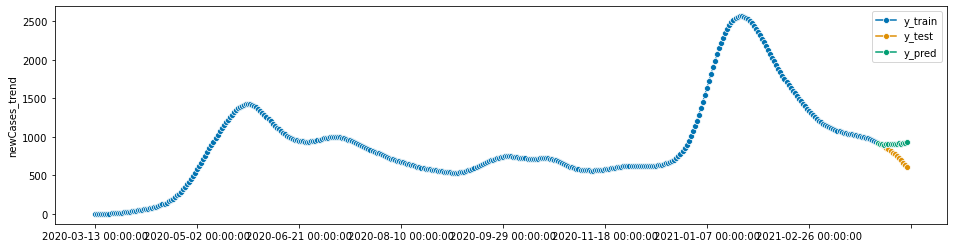

In [140]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [141]:
cv = ExpandingWindowSplitter(initial_window=20, step_length=1,fh=fh)
results = evaluate(forecaster=model, y=y, cv=cv)

In [142]:
results.tail(30)

,cutoff,fit_time,len_train_window,pred_time,test_sMAPE
335,2021-03-02,0.020943,355,0.004987,0.039325
336,2021-03-03,0.018949,356,0.003990,0.070296
337,2021-03-04,0.017953,357,0.003989,0.039612
338,2021-03-05,0.017952,358,0.004987,0.018926
339,2021-03-06,0.018949,359,0.003990,0.068512
340,2021-03-07,0.018950,360,0.003989,0.052914
341,2021-03-08,0.019947,361,0.003989,0.019259
342,2021-03-09,0.021941,362,0.003990,0.029466
343,2021-03-10,0.021449,363,0.004987,0.023290
344,2021-03-11,0.020944,364,0.004987,0.027761


In [143]:
print(f"sMAPE Médio dos Últimos 30 dias: {results['test_sMAPE'].tail(30).mean() * 100:.2f} %")

sMAPE Médio dos Últimos 30 dias: 6.52 %


In [149]:
results['test_sMAPE'].tail(5).mean()

0.14667780893054183

In [151]:
def treinar_modelo(params):

    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]

    print(params, '\n')
    
    
    regressor = LGBMRegressor(random_state=SEED,
    learning_rate = learning_rate, 
    num_leaves = num_leaves, 
    min_child_samples = min_child_samples, 
    subsample = subsample,
    colsample_bytree = colsample_bytree,
    subsample_freq=1,
    n_estimators=n_estimators)
    
    model = make_reduction(estimator = regressor, 
                           window_length= gscv.best_params_['window_length'], 
                           scitype='tabular-regressor', 
                           strategy='recursive')
    
    results = evaluate(forecaster=model, y=y, cv=cv)
    
    mean = results['test_sMAPE'].tail(5).mean()
    
    return mean

space = [
(1e-3, 1e-1, 'log-uniform'), #learning rate
(2, 128), #num_leaves
(1, 100), #min_child_samples
(0.05, 1.0), #subsample
(0.1, 1.0), #colsample_bytree
(100, 1000)] #n_estimators

result = dummy_minimize(treinar_modelo, 
space,
random_state=4, 
verbose=1,
n_calls = 30)

Iteration No: 1 started. Evaluating function at random point.
[0.06327656730105531, 71, 2, 0.8628399009188652, 0.6481320413049753, 493] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 107.7902
Function value obtained: 0.1066
Current minimum: 0.1066
Iteration No: 2 started. Evaluating function at random point.
[0.0027050730096210155, 105, 95, 0.7134992241139206, 0.9128606713660984, 776] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.7769
Function value obtained: 0.5045
Current minimum: 0.1066
Iteration No: 3 started. Evaluating function at random point.
[0.03620477422893411, 40, 53, 0.9842306433165472, 0.24745801726422886, 249] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.0649
Function value obtained: 0.1349
Current minimum: 0.1066
Iteration No: 4 started. Evaluating function at random point.
[0.042062540164342105, 127, 57, 0.0919520550349246, 0.9609876709428125, 748] 



LightGBMError: Check failed: (num_data) > (0) at D:\a\1\s\python-package\compile\src\io\dataset.cpp, line 33 .


In [22]:
result.x

[0.06180197188255592, 10, 38, 0.8203596896072781, 0.213563492506852, 666]

In [23]:
learning_rate, num_leaves, min_child_samples, subsample, colsample_bytree, n_estimators = result.x

In [60]:
regressor = LGBMRegressor(random_state=SEED,
    learning_rate = learning_rate, 
    num_leaves = num_leaves, 
    min_child_samples = min_child_samples, 
    subsample = subsample,
    colsample_bytree = colsample_bytree,
    subsample_freq=1,
    n_estimators=n_estimators)

NameError: name 'learning_rate' is not defined

In [67]:
model = make_reduction(estimator = regressor, 
                           window_length= gscv.best_params_['window_length'], 
                           scitype='tabular-regressor', 
                           strategy='recursive')

NameError: name 'RecursiveRegressionForecaster' is not defined

In [27]:
model.fit(y)

0.2703085742385957

In [ ]:
results = model.predict(fh)